Download dependencies

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.optim as optim
import torch.nn.functional as F
device = 'mps'

Define image transformations and make dataloaders for Tiny-ImageNet dataset

In [2]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
     ])
transform_test = transforms.Compose(
    [transforms.ToTensor(),
     ])

batch_size = 512

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Make and train a VGG8 model

In [3]:
from collections import OrderedDict, defaultdict


class VGG(nn.Module):

  def __init__(self) -> None:
    super().__init__()

    layers = []
    layers+=self.make_conv_layer(3,64,0)
    layers+=self.make_conv_layer(64,128,1)
    layers+=self.make_max_pool_layer(2,1)
    layers+=self.make_conv_layer(128,256,2)
    layers+=self.make_conv_layer(256,256,3)
    layers+=self.make_max_pool_layer(2,2)
    layers+=self.make_conv_layer(256,512,4)
    layers+=self.make_conv_layer(512,512,5)
    layers+=self.make_max_pool_layer(2,3)
    layers+=self.make_conv_layer(512,512,6)
    layers+=self.make_conv_layer(512,512,7)
    layers+=self.make_max_pool_layer(2,4)
    
    self.backbone = nn.Sequential(OrderedDict(layers))
    print(self.backbone)
    self.classifier = nn.Linear(512, 10)

  def forward(self, x):
    x = self.backbone(x)
    x = x.mean([2, 3])
    x = self.classifier(x)
    return x
  
  def make_conv_layer(self, channels_in, channels_out, count):
    return [
      (f'conv{count}', nn.Conv2d(channels_in, channels_out, 3, padding=1, bias=False)),
      (f'bn{count}', nn.BatchNorm2d(channels_out)),
      (f'relu{count}', nn.ReLU(inplace=True))
    ]

  def make_max_pool_layer(self, kernel, count):
    return [(f'pool{count}', nn.MaxPool2d(kernel))]

In [4]:
# helper function to train a model
def train(model, dataloader, learning_rate=1e-3, num_epochs=5):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,total_iters=num_epochs)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")
        scheduler.step()
    
    print("Training complete!")

def get_num_parameters(model, count_nonzero_only=False):
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

# helper function for evaluating a models test performance
def eval_model(model, testloader, count_nonzero_only):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    acc = f'Test Accuracy: {100.0 * correct / total}'
    num_params = get_num_parameters(model, count_nonzero_only)
    params = f'Number of parameters: {num_params}'
    MiB = 1024 * 1024 * 8
    size = f'Size: {num_params*32/MiB:.2f} MiB'
    print(acc, params, size)


Initialize model and Test initial performance

In [5]:
model = VGG().eval().to(device)
pretrained_state_dict = torch.load('vgg.cifar.pretrained.pth', map_location='cpu')['state_dict']
print(pretrained_state_dict)
model.load_state_dict(pretrained_state_dict)
eval_model(model, testloader, False)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

100%|██████████| 20/20 [00:17<00:00,  1.15it/s]

Test Accuracy: 92.95 Number of parameters: 9228362 Size: 35.20 MiB


Show pre-trained model weight histograms

[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]


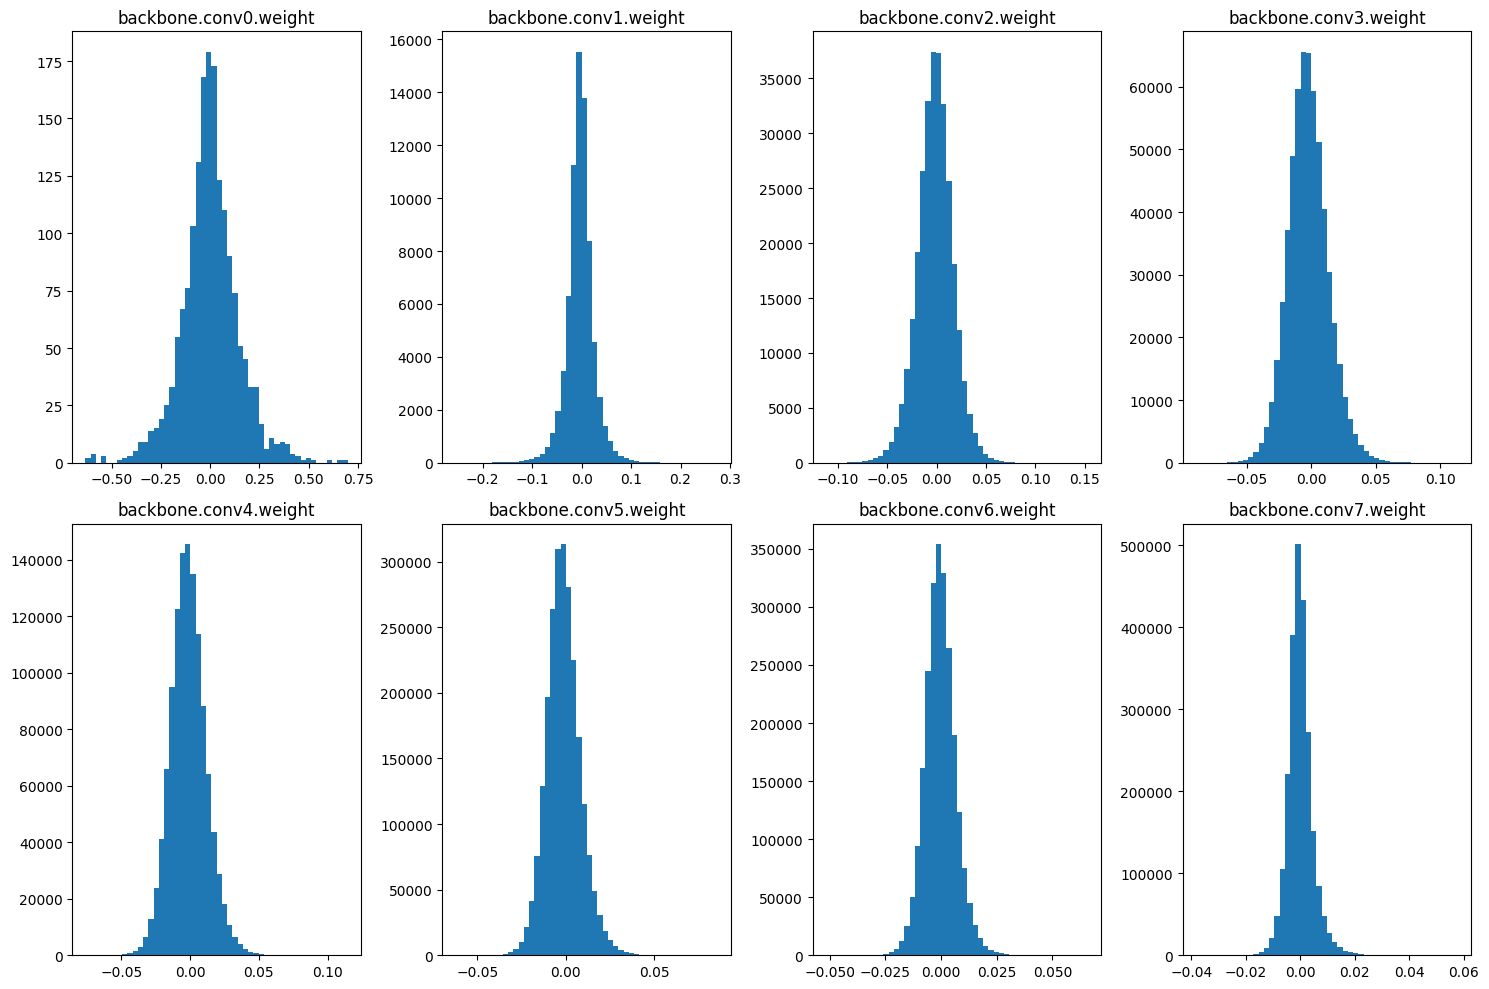

In [6]:
def plot_weights_histogram(model, include_zeros=True):
    """
    Plot histograms of weights for each layer in a PyTorch model.

    :param model: A PyTorch neural network model
    :param include_zeros: If true, include a bin for values of 0 in the histogram
    """
    # Check the number of layers with parameters

    valid_named_params = [(name,param) for name,param in model.named_parameters() if param.dim()>1]
    num_layers = len(valid_named_params)

    # Create subplots
    fig, axes = plt.subplots(2,num_layers//2, figsize=(15,10))
    if num_layers == 1:
        axes = [axes]  # make sure axes is always a list for consistency

    axes= list(np.array(axes).flatten())
    print(axes)

    # Loop through layers and plot histograms
    for ax, (name, param) in zip(axes, valid_named_params):
        if not param.dim()>1:
            continue
        data = param.detach().cpu().numpy().flatten()
        
        if not include_zeros:
            data = data[data != 0]

        ax.hist(data, bins=50)
        ax.set_title(f"{name}")

    plt.tight_layout()
    plt.show()


    
plot_weights_histogram(model, include_zeros=True)

Implement pruning

In [7]:
from copy import deepcopy

# chosen through trial+error & from # params
sparsities = {
            'backbone.conv0.weight': 0.2,
            'backbone.conv1.weight': 0.6,
            'backbone.conv2.weight': 0.6,
            'backbone.conv3.weight': 0.4,
            'backbone.conv4.weight': 0.4,
            'backbone.conv5.weight': 0.8,
            'backbone.conv6.weight': 0.85,
            'backbone.conv7.weight': 0.9,
            'classifier.weight': 0.5}

def prune_layer(layer: torch.tensor, sparsity):
    # calc # of weights to keep
    num_to_keep = round(sparsity*layer.flatten().size(0))

    # calc the importance of each weight based on their magnitude
    mag_importance = torch.abs(layer)

    # get the threshold value for pruning
    prune_thresh = torch.topk(mag_importance.flatten(),num_to_keep, largest=False).values.max()

    # get bool mask of wether a weight is kept
    mask = torch.gt(mag_importance, prune_thresh)
    print(mask.flatten().sum(), layer.flatten().size(0))
    return layer*mask


pruned_model = deepcopy(model)
pruned_model = pruned_model.to(device)
masks={}
for name, param in tqdm(pruned_model.named_parameters()):
    if param.dim()>1: # conv or fc
        masks[name] = prune_layer(param, sparsities[name])
        param.data = masks[name]

26it [00:00, 127.35it/s]

tensor(1382, device='mps:0') 1728
tensor(29491, device='mps:0') 73728
tensor(117965, device='mps:0') 294912
tensor(353894, device='mps:0') 589824
tensor(707789, device='mps:0') 1179648
tensor(471859, device='mps:0') 2359296
tensor(353894, device='mps:0') 2359296
tensor(235930, device='mps:0') 2359296
tensor(2560, device='mps:0') 5120


Sparsity level of conv1: 60.00%


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Test Accuracy: 83.81 Number of parameters: 2280278 Size: 8.70 MiB
[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]


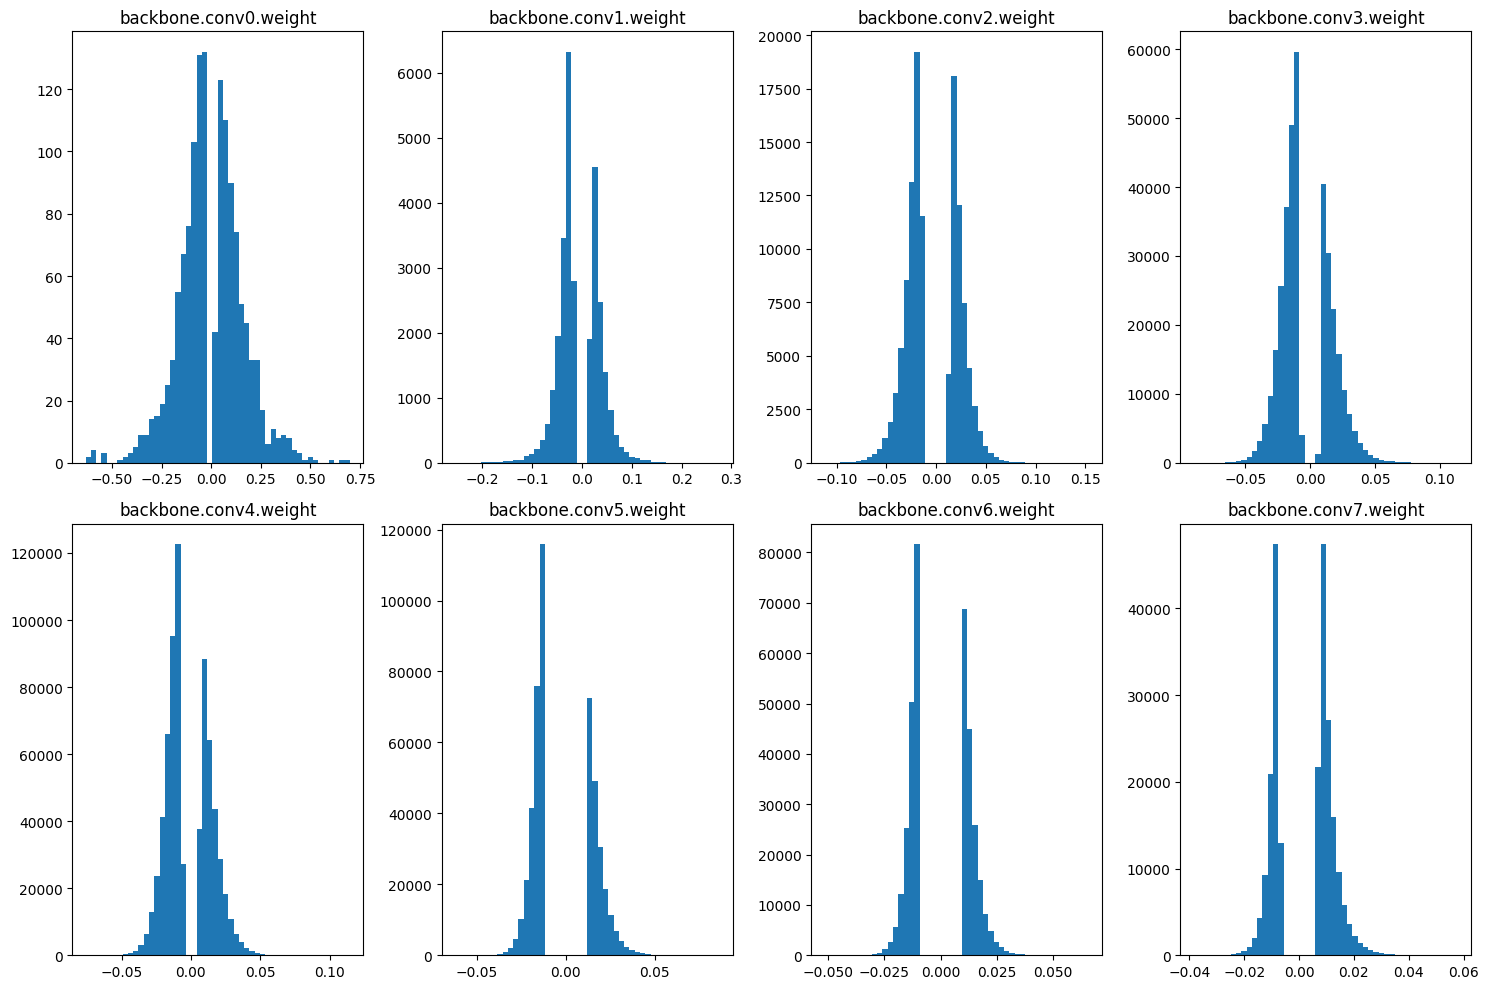

In [8]:
# evaluate the pruned model's new weight histogram
pruned_model.eval()
num_zero_params = (pruned_model.backbone.conv1.weight.flatten() == 0).float().sum().item()
total_params = pruned_model.backbone.conv1.weight.numel()
sparsity_level = num_zero_params / total_params * 100
print(f"Sparsity level of conv1: {sparsity_level:.2f}%")    # sanity check to make sure pruning works

eval_model(pruned_model, testloader, True)
plot_weights_histogram(pruned_model, include_zeros=False)

Finetune the pruned model

100%|██████████| 98/98 [01:36<00:00,  1.01it/s]


Epoch [1/5] Loss: 0.0451


100%|██████████| 98/98 [01:24<00:00,  1.15it/s]


Epoch [2/5] Loss: 0.0451


100%|██████████| 98/98 [01:23<00:00,  1.17it/s]


Epoch [3/5] Loss: 0.0436


100%|██████████| 98/98 [01:23<00:00,  1.18it/s]


Epoch [4/5] Loss: 0.0434


100%|██████████| 98/98 [01:23<00:00,  1.17it/s]


Epoch [5/5] Loss: 0.0412
Training complete!


7it [00:00, 56.87it/s]

tensor(1382, device='mps:0') 1728
tensor(29491, device='mps:0') 73728
tensor(117965, device='mps:0') 294912
tensor(353894, device='mps:0') 589824
tensor(707789, device='mps:0') 1179648
tensor(471859, device='mps:0') 2359296
tensor(353894, device='mps:0') 2359296


26it [00:00, 78.60it/s]


tensor(235930, device='mps:0') 2359296
tensor(2560, device='mps:0') 5120
Finetuned & Pruned model


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Test Accuracy: 92.05 Number of parameters: 2280278 Size: 8.70 MiB
[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]


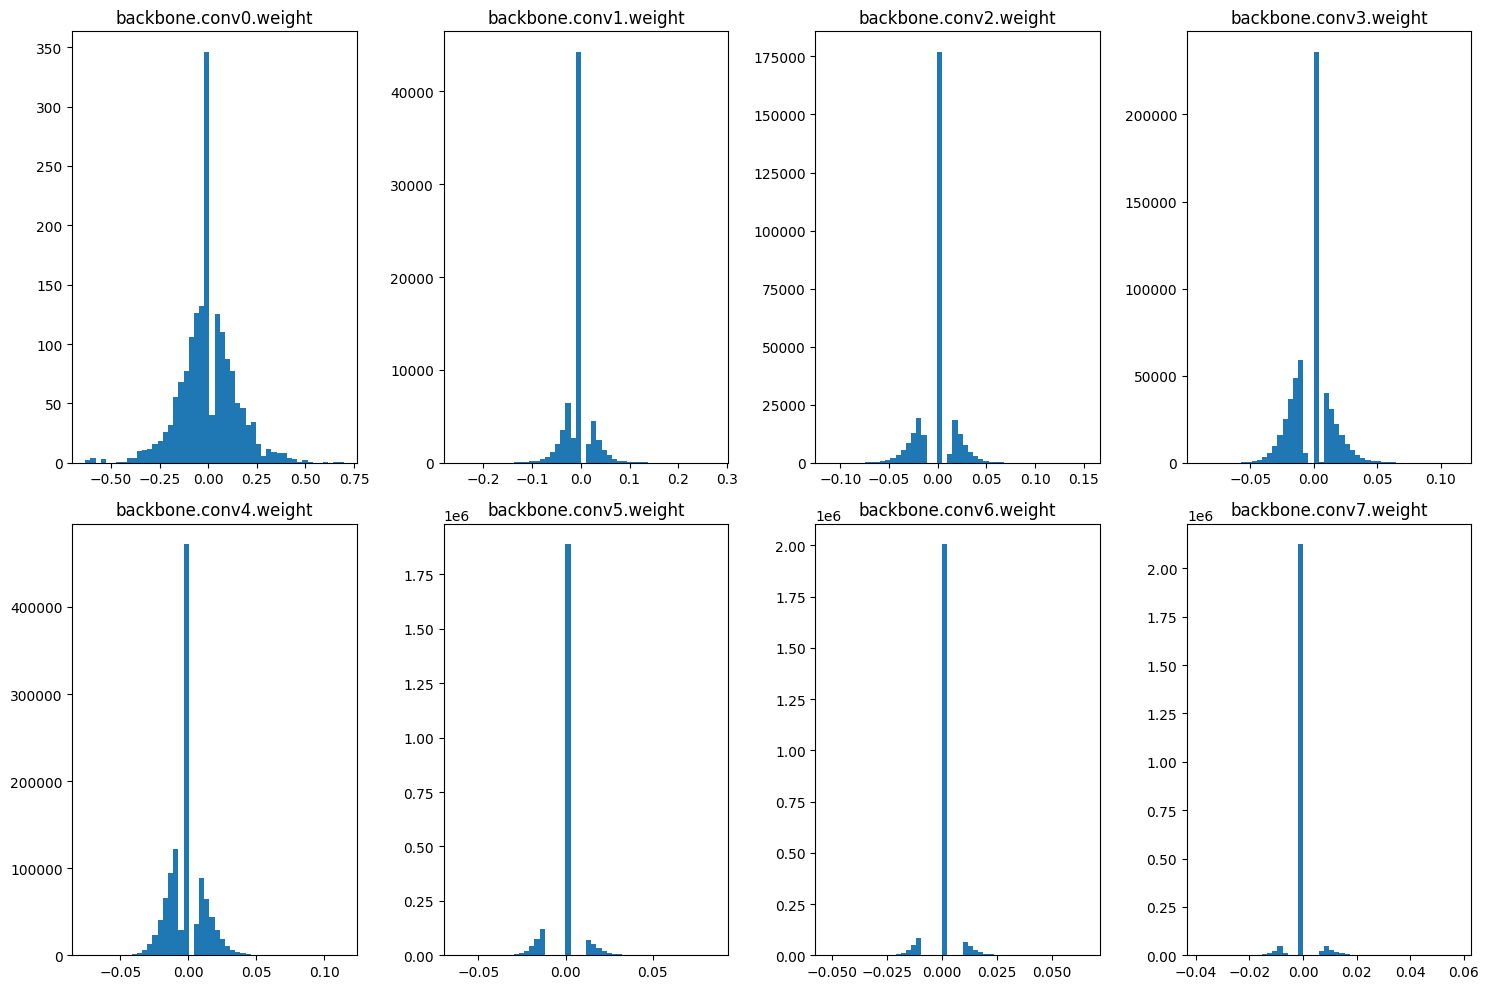

Original model:


100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


Test Accuracy: 92.95 Number of parameters: 9228362 Size: 35.20 MiB
[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]


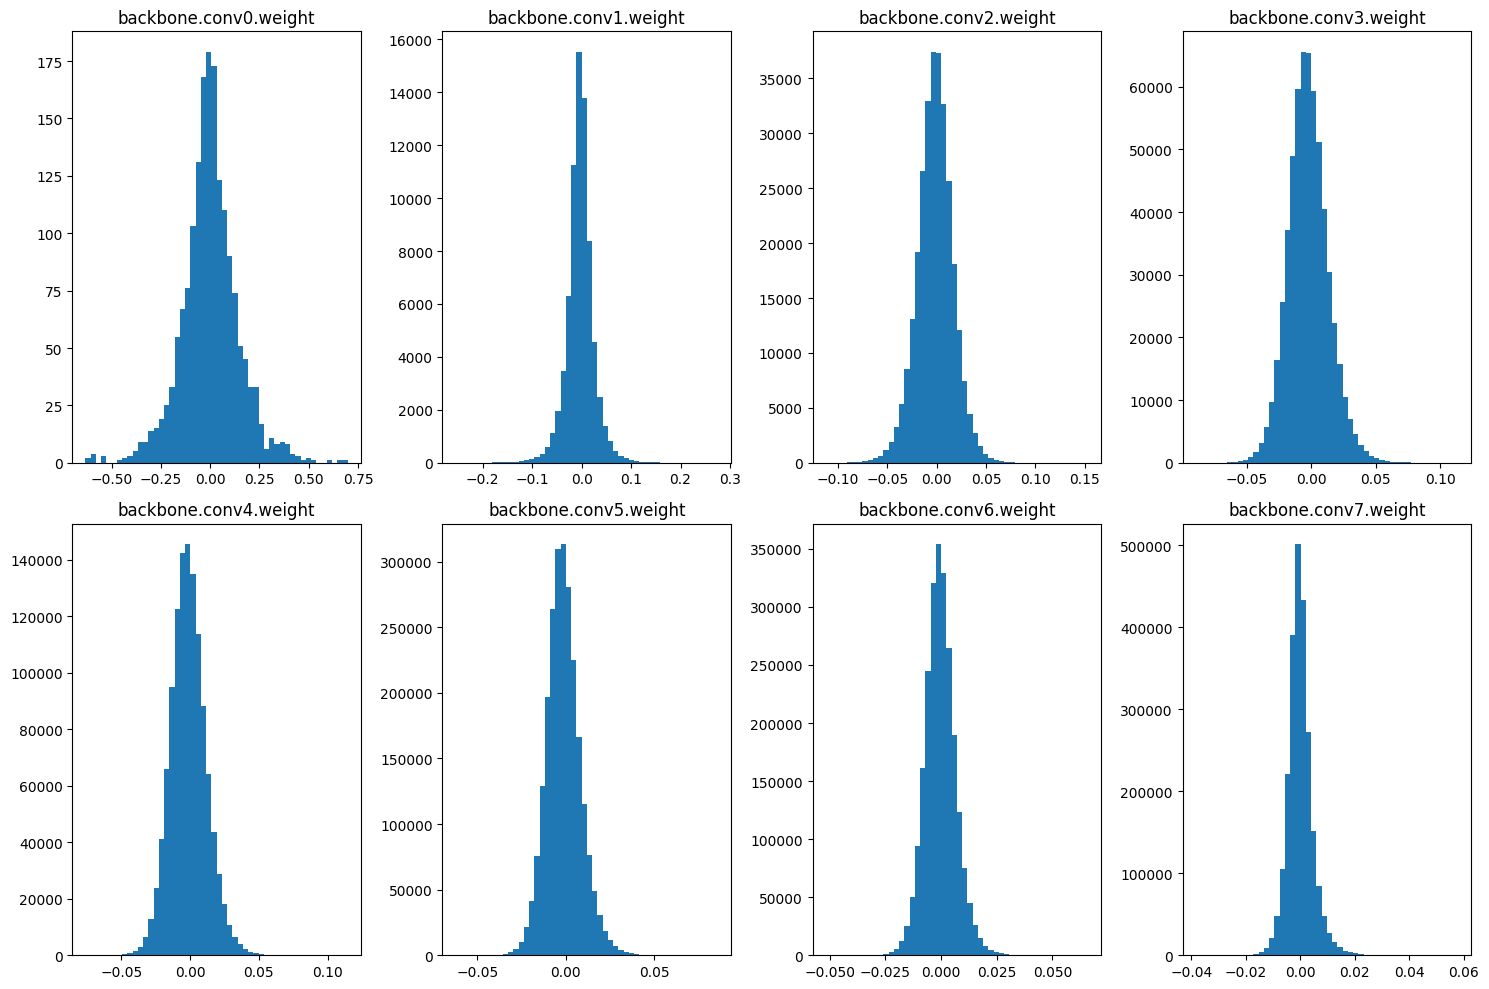

In [10]:
train(pruned_model, trainloader, learning_rate=1e-3, num_epochs=5)
# apply mask from previous pruning since model weights have changed
for name, param in tqdm(pruned_model.named_parameters()):
    if param.dim()>1: # conv or fc
        masks[name] = prune_layer(param, sparsities[name])
        param.data = masks[name]


print('Finetuned & Pruned model')
eval_model(pruned_model, testloader, True)
plot_weights_histogram(pruned_model, include_zeros=True)

# compare with original
print('Original model:')
eval_model(model, testloader, False)
plot_weights_histogram(model, include_zeros=True)